In [1]:
import cv2
import numpy as np
import os
from PIL import Image
import shutil
import random

#Preparación para la creación de conjuntos de datos.

A continuación se definen tres funciones: apply_filters_and_convolutions, copiar_y_convertir y creación_conjuntos.

Como indica su nombre apply_filters_and_convolutions aplica filtros sobre una las imágenes, recibe como argumentos la imagen convertida en array, un filtro en específico y un kernel (solo si se pasa como filtro "custom"). Los filtros disponibles son "blur" (gaussianBlur), "sobel" y "custom"; este último debe acompañarse con un kernel.

La siguiente función es copiar_y_convertir, lo que hace es trasladar una copia de una imagen del directorio original de la base de datos a otro directorio, en el proceso aplica la función anterior, es por ello que esta función también recibe como argumentos filter y kernel. Los otros argumentos son directorio de origen, directorio de destino, y nombre de la imagen.

La última función es creacion_conjuntos, esta crea los conjuntos de entrenamiento, validación y test. Para ello emplea las dos funciones anteriores. Recibe como argumentos: "lab" es de label, es el nombre que se utiliza para diferenciar entre diferentes instancias de la función, por ejemplo si se escribe "sobel", creará el directorio de entrenamiento con el nombre "train_sobel"; "base_dir" es la dirección del directorio base sobre el que se van a crear el conjunto de entrenamiento, validación y test; "categories" en una lista con los nombres de las categorias, no importa el nombre como tal, únicamente que correspondan en el orden con la siguiente categoría; "dir_categories" es una lista de las direcciones de los directorios originales en los que se encuentran separadas las imágenes por categorías, de preferencia deben aparecer en el mismo orden que en el argumento anterior; finalmente recibe "filter" y "kernel", que son los mismos que ya se definieron para las dos funciones anteriores.

In [8]:
def apply_filters_and_convolutions(image, filter = None, kernel = None):

    if filter == None:
      img = image

    elif filter == "blur":
      # Aplicar un filtro de desenfoque (blur)
      img = cv2.GaussianBlur(image, (5, 5), 0)
      print("ok")

    elif filter == "sobel":

      # Paso 1: Suavizar para reducir ruido pero preservar bordes grandes
      blurred = cv2.GaussianBlur(image, (5, 5), 1)

      # Paso 2: Aplicar Laplaciano
      laplacian = cv2.Laplacian(blurred, cv2.CV_64F)

      sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
      sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
      sobel_mag = np.sqrt(sobel_x**2 + sobel_y**2)

      # Normalizar a uint8 (0–255)
      img = cv2.convertScaleAbs(sobel_mag)

      _,img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)


    elif filter == "custom":
      # Aplicar un filtro de convolución personalizado
      try:
        img = cv2.filter2D(image, -1, kernel)
      except:
        print("Kernel inválido")


    return img

In [9]:
#Esta función recibe como parámetros una carpeta de origen y de destino, así como el nombre de un archivo
#Lo que hace esta función es copiar este archivo entre carpetas con las siguientes consideraciones: se pasará convertido a grayscale, unit8 y en formado .jpg

def copiar_y_convertir(carpeta_origen, carpeta_destino, nombre_archivo,filter = None, kernel=None):

    # Ruta completa del archivo original
    ruta_original = os.path.join(carpeta_origen, nombre_archivo)

    # Obtener nombre sin extensión y armar ruta de destino .jpg
    nombre_sin_ext = os.path.splitext(nombre_archivo)[0]
    nombre_destino = nombre_sin_ext + ".jpg"
    ruta_destino = os.path.join(carpeta_destino, nombre_destino)

    try:
        img = Image.open(ruta_original).convert('L') # Abre la imagen y la convierte a escala de grises
        img_array = np.asarray(img)

        #Convierte las imagenes a unit8, o sea que se pasa todas las imagenes a una escala de o a 255
        if img_array.dtype != np.uint8:
            if img_array.max() <= 1.0:
                img_array = (img_array * 255).astype(np.uint8)
            else:
                img_array = img_array.astype(np.uint8)
        # Aplicar filtro
        if filter != None:
          img_array = apply_filters_and_convolutions(img_array, filter=filter, kernel=kernel)

        img = Image.fromarray(img_array, mode='L')

        # Guardar en la carpeta destino como JPG, así se evitan problemas a la hora de abrir las imagenes, pues todas tienen la misma extensión
        img.save(ruta_destino, format="JPEG")

    except Exception as e:
        print(f"Error al copiar '{nombre_archivo}': {e}")

In [10]:
#lab: Es una etiqueta para diferenciar entre sets de datos para filtros diferentes.
#base_dir: Es la dirección del directorio en el que se van a crear los conjuntos de entrenamiento, validación y test.
#categories: Es una lista con los nombres de las categorías, en este caso ["yes","no"] (Con tumor o sin tumor).
#dir_categories: Es una lista con las direcciones de las carpetas de imágenes por categorías. Deben aparecer en el mismo orden que categories.

def creacion_conjuntos(lab="", base_dir="",categories=[], dir_categories=[], filter = None, kernel = None):
  direcciones_finales = []
  conjuntos = ["train", "validation", "test"]
  dir_conjuntos = []
  names_per_category = []
  try:
    if os.path.isdir(base_dir): #Pregunta si el directorio base existe
      print("El directorio base ya existe.")
    else:
      os.mkdir(base_dir) #Si el directorio base no existe lo crea

    #Dentro del directorio base se van a crear directorios de entrenamiento, validación y test

    for i in conjuntos:
      dir = os.path.join(base_dir, '{}_{}'.format(i,lab)) # Dirección de conjunto de entrenamiento, validación o test
      os.mkdir(dir) #Creación de directorio
      dir_conjuntos.append(dir) # Se guarda la dirección del directorio en el orden -> train, validation y test
  except:
    print("Ocurrio un error al intentar crear los directorios raíz")

  #Se va a crear un directorio por categoría para entrenamiento, validación y test

  for i in categories:
    try:
      for j in dir_conjuntos:
        dir_final = os.path.join(j, i) # j representa la dirección del conjunto de train, validation o test, e i representa la categoría. Ambos se juntan para crear la dirección del directorio de la categoría i.
        direcciones_finales.append(dir_final) # Se agrega la dirección a una nueva lista
        os.mkdir(dir_final) # Se crea el directorio
    except:
      print("Ocurrio un error al intentar crear los directorios finales")

  # Se van a distribuir las imagenes de la base de datos en los directorios de entrenamiento, validación y test, separados por categoría

  for i in dir_categories:
    names_per_category.append([filename for filename in os.listdir(i)]) #names_per_category es una lista de listas de filenames por categoría

  for i in range(len(categories)):
    k = 0 #contador
    for name in names_per_category[i]: #Se van a distrubuir los nombres de las imágenes de la categoría i en los diferentes conjuntos
      if k <= int(len(names_per_category[i])*0.8): #Indica que el 80% de los datos de la categoría i van a parar al directorio de la categoría i dentro del conjunto de entrenamiento
        copiar_y_convertir(dir_categories[i], direcciones_finales[i*3], name,filter=filter,kernel=kernel)# copiar_y_convertir recibe la dirección de origen, la final y la dirección de la imagen que se va a mover
      elif (k > int(len(names_per_category[i])*0.8)) and (k <= int(len(names_per_category[i])*0.9)):
        copiar_y_convertir(dir_categories[i], direcciones_finales[i*3 + 1], name,filter=filter, kernel=kernel)
      else:
        copiar_y_convertir(dir_categories[i], direcciones_finales[i*3 + 2], name, filter=filter, kernel=kernel)
      k += 1
  return dir_conjuntos

#Creación de conjunto de datos

In [189]:
original_dataset_dir = "/content/drive/MyDrive/Diplomado en ciencia de datos/Diplomado en Ciencia de Datos/Modulo_5/Proyectos de redes neuronales/brain_tumor_dataset"
orig_yes_dir = os.path.join(original_dataset_dir, 'yes')
orig_no_dir = os.path.join(original_dataset_dir, 'no')

#Dirección del directorio base sobre el que se van a crear los directorios train, validation y test
base_dir = '/content/drive/MyDrive/Diplomado en ciencia de datos/Diplomado en Ciencia de Datos/Modulo_5/Proyectos de redes neuronales/brain_tumor_dataset/Conjuntos_de_datos'

cat = ["yes","no"] #Categorías
dir = [orig_yes_dir, orig_no_dir] #Direcciones de categorías

#Creación de conjuntos de datos
train_dir, validation_dir, test_dir = creacion_conjuntos(lab="", base_dir= base_dir, categories= cat, dir_categories= dir)


In [80]:
#Comprobación de que las imágenes se hayan separado correctamente entre el conjunto de entrenamiento, validación y test.

train_data_yes = [filename for filename in os.listdir(os.path.join(train_dir,"yes"))] #Lista de todos los nombres de imágenes en el directorio de entrenamiento para la categoría "yes"
train_data_no = [filename for filename in os.listdir(os.path.join(train_dir,"no"))] #Lista de todos los nombres de imágenes en el directorio de entrenamiento para la categorías "no"
validation_data_yes = [filename for filename in os.listdir(os.path.join(validation_dir,"yes"))]
validation_data_no = [filename for filename in os.listdir(os.path.join(validation_dir,"no"))]
test_data_yes = [filename for filename in os.listdir(os.path.join(test_dir,"yes"))]
test_data_no = [filename for filename in os.listdir(os.path.join(test_dir,"no"))]

train_total = train_data_yes + train_data_no
validation_total = validation_data_yes + validation_data_no
test_total = test_data_yes + test_data_no

comunes = set(train_total) & set(validation_total) & set(test_total) # Verificación de que no tengan elementos en común los diferentes conjuntos

print(comunes)
print(len(train_total))
print(len(validation_total))
print(len(test_total))

set()
203
25
24


#Data Augmentation.

In [29]:
!pip install tensorflow

In [81]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,               # Rotaciones leves
                                   width_shift_range=0.05,         # Desplazamiento pequeño horizontal
                                   height_shift_range=0.05,        # Desplazamiento pequeño vertical
                                   zoom_range=0.05,                # Pequeños zoom
                                   brightness_range=[0.9, 1.1],    # Variación de brillo leve
                                   shear_range=0.02,               # Distorsión angular leve
                                   fill_mode='nearest',            # Relleno sin pérdida de bordes
                                   horizontal_flip=False)          # No voltear horizontalmente

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=12,
                                                    class_mode='binary',
                                                    color_mode='grayscale',
                                                    shuffle = True)

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=5,
                                                        class_mode='binary',
                                                        color_mode='grayscale',shuffle = True)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=4,
                                                  class_mode='binary',
                                                  shuffle=False,
                                                  color_mode='grayscale')



Found 203 images belonging to 2 classes.
Found 25 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


#Modelo

In [82]:
from keras import layers
from keras import models
from keras import optimizers
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode="min",
    patience=10,
    restore_best_weights=True
    )


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150,150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=16,
                    epochs=120,
                    validation_data=validation_generator,
                    validation_steps=5,
                    callbacks=[early_stopping])

Epoch 1/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 672ms/step - acc: 0.5551 - loss: 0.6789 - val_acc: 0.6000 - val_loss: 0.6319
Epoch 2/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - acc: 0.5000 - loss: 0.7116 - val_acc: 0.6000 - val_loss: 0.6263
Epoch 3/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 532ms/step - acc: 0.6203 - loss: 0.6509 - val_acc: 0.6400 - val_loss: 0.5994
Epoch 4/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - acc: 0.8333 - loss: 0.5346 - val_acc: 0.6000 - val_loss: 0.5999
Epoch 5/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 582ms/step - acc: 0.6579 - loss: 0.6152 - val_acc: 0.7600 - val_loss: 0.5549
Epoch 6/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - acc: 0.6667 - loss: 0.6312 - val_acc: 0.7600 - val_loss: 0.5513
Epoch 7/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 657ms/step - acc: 0.7256 - loss: 0.5944 - val_acc: 0.8000 - val_loss: 0.5196
Epoch 8/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - acc: 0.6667 - loss: 0.5727 - val_acc: 0.8000 - val_loss: 0.5188
Epoch 9/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 578ms/s

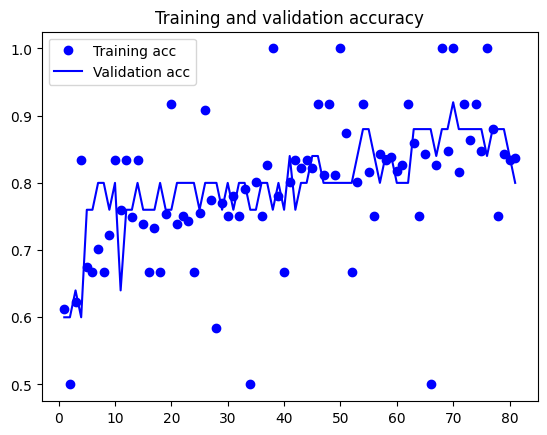

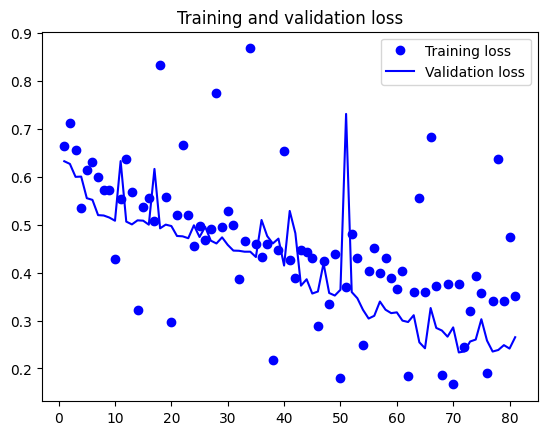

In [83]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [84]:
loss, accuracy = model.evaluate(test_generator, steps=6)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - acc: 0.6935 - loss: 0.4368
Loss: 0.4099, Accuracy: 0.7500


#Modelo aplicando sobel como filtro.

Sobel es un filtro de detección de bordes que resalata las transiciones bruscas de intensidad en una imagen. El problema en cuestión es clasificar imágenes de resonancias magnéticas en "yes" (con tumor) y "no" (sin tumor), entonces el objetivo es aplicar un filtro que haga más aparente la presencia del tumor. En este caso sobel resulta valioso, pues los tumores se caracterizan por tener bordes muy marcados.

In [12]:
original_dataset_dir = "/content/drive/MyDrive/Diplomado en ciencia de datos/Diplomado en Ciencia de Datos/Modulo_5/Proyectos de redes neuronales/brain_tumor_dataset"
orig_yes_dir = os.path.join(original_dataset_dir, 'yes')
orig_no_dir = os.path.join(original_dataset_dir, 'no')

#Dirección del directorio base sobre el que se van a crear los directorios train, validation y test
base_dir = '/content/drive/MyDrive/Diplomado en ciencia de datos/Diplomado en Ciencia de Datos/Modulo_5/Proyectos de redes neuronales/brain_tumor_dataset/Conjuntos_de_datos'

cat = ["yes","no"] #Categorías
dir = [orig_yes_dir, orig_no_dir] #Direcciones de categorías

#Creación de folders de conjunto de datos
train_dir_sobel, validation_dir_sobel, test_dir_sobel = creacion_conjuntos(lab="sobel", base_dir=base_dir, categories=cat, dir_categories=dir, filter="sobel")

El directorio base ya existe.


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,               # Rotaciones leves (evita giros exagerados)
                                   width_shift_range=0.05,         # Desplazamiento pequeño horizontal
                                   height_shift_range=0.05,        # Desplazamiento pequeño vertical
                                   zoom_range=0.05,                # Pequeños zoom in/out
                                   brightness_range=[0.9, 1.1],    # Variación de brillo leve
                                   shear_range=0.02,               # Distorsión angular leve (como cambio de inclinación)
                                   fill_mode='nearest',            # Relleno sin pérdida de bordes
                                   horizontal_flip=False           # No voltear horizontalmente (anatómicamente peligroso)
                                                        )
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir_sobel,
                                                    target_size=(150, 150),
                                                    batch_size=12,
                                                    class_mode='binary',
                                                    color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(validation_dir_sobel,
                                                        target_size=(150, 150),
                                                        batch_size=5,
                                                        class_mode='binary',
                                                        color_mode='grayscale')

test_generator = test_datagen.flow_from_directory(test_dir_sobel,
                                                  target_size=(150, 150),
                                                  batch_size=4,
                                                  class_mode='binary',
                                                  shuffle=False,
                                                  color_mode='grayscale'
                                                  )

Found 203 images belonging to 2 classes.
Found 25 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


In [15]:
from keras import layers
from keras import models
from keras import optimizers
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode="min",
    patience=10,
    restore_best_weights=True
    )


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150,150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=16,
                    epochs=120,
                    validation_data=validation_generator,
                    validation_steps=5,
                    callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 625ms/step - acc: 0.5728 - loss: 0.6830 - val_acc: 0.6800 - val_loss: 0.6443
Epoch 2/120
 1/16 ━━━━━━━━━━━━━━━━━━━━ 7s 512ms/step - acc: 0.7500 - loss: 0.5420

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - acc: 0.7500 - loss: 0.5420 - val_acc: 0.6800 - val_loss: 0.6227
Epoch 3/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 714ms/step - acc: 0.6975 - loss: 0.6279 - val_acc: 0.7600 - val_loss: 0.4952
Epoch 4/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - acc: 0.6667 - loss: 0.6863 - val_acc: 0.7600 - val_loss: 0.4937
Epoch 5/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 735ms/step - acc: 0.7691 - loss: 0.4894 - val_acc: 0.8000 - val_loss: 0.4867
Epoch 6/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - acc: 0.7500 - loss: 0.4525 - val_acc: 0.7600 - val_loss: 0.5194
Epoch 7/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 735ms/step - acc: 0.7211 - loss: 0.5179 - val_acc: 0.8400 - val_loss: 0.4683
Epoch 8/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - acc: 0.8333 - loss: 0.5831 - val_acc: 0.8400 - val_loss: 0.4658
Epoch 9/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 740ms/step - acc: 0.7929 - loss: 0.4702 - val_acc: 0.7600 - val_loss: 0.4766
Epoch 10/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 

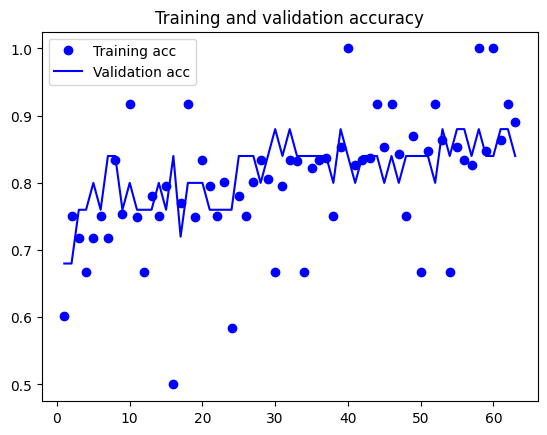

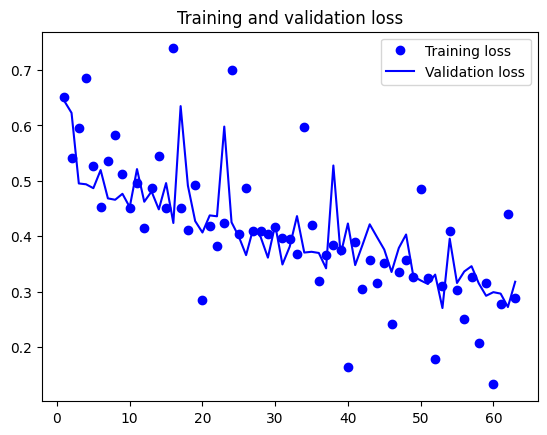

In [16]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [17]:
loss, accuracy = model.evaluate(test_generator, steps=6)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - acc: 0.8167 - loss: 0.4213
Loss: 0.3569, Accuracy: 0.8333
